An example script for using texturegan model

In [91]:
# from google.colab import drive
# drive.mount('/content/drive')

In [92]:
%cd /content/drive/MyDrive/OurGAN/

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/OurGAN/'
C:\Users\ASUS\Desktop\OurGAN


In [93]:
#!ls

In [94]:
!pip install visdom

In [95]:
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org torch==0.4.1.post2 torchvision==0.2.1 -f https://download.pytorch.org/whl/torch_stable.html

In [96]:
#!pip install numpy==1.15.0

In [97]:
import numpy as np

In [98]:
import cv2
#import numpy as np
from matplotlib import pyplot as plt

In [99]:
np.version.version

'1.21.5'

In [100]:
from argparser import parse_arguments

In [101]:
from PIL import Image

In [102]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [103]:
#dummy command
command = '--display_port 7770 --load 0 --load_D -1 --load_epoch 105 --gpu 2 --model texturegan --feature_weight 1e2 --pixel_weight_ab 1e3 --global_pixel_weight_l 1e3 --local_pixel_weight_l 0 --style_weight 0 --discriminator_weight 1e3 --discriminator_local_weight 1e6  --learning_rate 1e-4 --learning_rate_D 1e-4 --batch_size 36 --save_every 50 --num_epoch 100000 --save_dir /hdd/2017IS013/researchGroup03/Pytorch_ARGAN/data/train_txt --load_dir /hdd/2017IS013/researchGroup03/Pytorch_ARGAN/data/train_txt --data_path /hdd/2017IS013/researchGroup03/Pytorch_ARGAN/data/ --learning_rate_D_local  1e-4 --local_texture_size 50 --patch_size_min 20 --patch_size_max 40 --num_input_texture_patch 1 --visualize_every 5 --num_local_texture_patch 1'
args = parse_arguments(command.split())


In [104]:
from main import get_transforms
from dataloader import imfol
from dataloader.imfol import ImageFolder, make_dataset
import torch
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader
import math
from torch.autograd import Variable
from utils.visualize import vis_patch, vis_image

## Load from validation folder

In [105]:
args.batch_size = 1
args.image_size =152
args.resize_max = 256
args.resize_min = 256
args.data_path = '/hdd/2017IS013/researchGroup03/Pytorch_ARGAN/data/' #change to your data path

In [106]:
transform = get_transforms(args)

In [107]:
#defaulty used
img_path = "C:/Users/ASUS/Desktop/OurGAN/data2/blank.jpg"

In [108]:
#convert input sketch to canny 
#path should be changed here
input_img = cv2.imread("C:/Users/ASUS/Desktop/OurGAN/data/2.jpeg") #path to cloth folder
#plt.imshow(input_img)

In [109]:
gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200)
ret,th2 = cv2.threshold(edges,100,255,cv2.THRESH_BINARY_INV)
sketch_image = "C:/Users/ASUS/Desktop/OurGAN/data/flecked_0145.jpg"  #path to save sketches images
cv2.imwrite(sketch_image, th2)


True

In [110]:
skg_path = sketch_image

In [111]:
img = cv2.imread(skg_path)

In [112]:
print(img.shape)

(256, 256, 3)


In [113]:
 #convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray)

In [114]:
#find the edges and cacluated thresholders with contours
thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
#plt.imshow(thresh)

In [115]:
edges = cv2.dilate(cv2.Canny(thresh,0,255), None)
#plt.imshow(edges)


In [116]:
masked = []
segmented = []


In [117]:
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]

In [118]:
#create a mask using largest contour
mask = np.zeros((256,256), np.uint8)
masked.append(cv2.drawContours(mask, [cnt], -1, 255, -1))

In [119]:
dst = cv2.bitwise_and(img, img, mask=mask)

In [120]:
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)


In [121]:
#plt.imshow(mask)

In [122]:
#plt.imshow(segmented)

In [123]:
filename = "C:/Users/ASUS/Desktop/OurGAN/data/seg.jpg"
cv2.imwrite(filename, mask)


True

In [124]:
#skg_path = "./dataset/test/shirt.jpg"
# seg_path = "./dataset/test/seg.jpg"
seg_path = filename

In [125]:
# eroded_seg_path = "./dataset/test/eroded_seg.jpg"
eroded_seg_path = filename

In [126]:
#Set the texture patch path here
txt_path = "C:/Users/ASUS/Desktop/OurGAN/data/rose.jpg"

In [127]:
img = pil_loader(img_path)
skg = pil_loader(skg_path)
seg = pil_loader(seg_path)
txt = pil_loader(txt_path)
eroded_seg = pil_loader(eroded_seg_path)
img, skg, seg, eroded_seg, txt = transform([img, skg, seg, eroded_seg, txt])
img = img.unsqueeze(0)
skg = skg.unsqueeze(0)
txt = txt.unsqueeze(0)
seg = seg.unsqueeze(0)
eroded_seg = eroded_seg.unsqueeze(0)
data = [img, skg, seg, eroded_seg, txt]

## Load Pretrained model

In [128]:
def load_network(model, save_path):
        
    model_state = torch.load(save_path)
    
    if "state_dict" in model_state:
        model.load_state_dict(model_state["state_dict"])
    else:
        model.load_state_dict(model_state)

        model_state = {
            'state_dict': model.cpu().state_dict(),
            'epoch': epoch,
            'iteration': iteration,
            'model': args.model,
            'color_space': args.color_space,
            'batch_size': args.batch_size,
            'dataset': dataset,
            'image_size': args.image_size
        }
    
    model.cpu()


In [129]:
from models import texturegan,discriminator

#change to your location
#model_location = '/hdd/2017IS013/researchGroup03/Pytorch-TextureGAN/resources/textureD_final_allloss_handbag_3300.pth'
model_location = 'C:/Users/ASUS/Desktop/OurGAN/trained_model/final_cloth_finetune.pth'

netG = texturegan.TextureGAN(5, 3, 32)
load_network(netG, model_location)

netG.eval()

TextureGAN(
  (model): Sequential(
    (main_model): MainModel(
      (main_model): Sequential(
        (conv_1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm_1): ReLU(inplace=True)
        (res_block_1): ResidualBlock(
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (batch_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm_2): ReLU(inplace=True)
        (res_blo

In [130]:
#data = valLoader.__iter__().__next__()
from utils import transforms as custom_transforms

In [131]:
def get_input(val_loader,xcenter,ycenter,patch_size,num_patch):
    img, skg, seg, eroded_seg, txt = val_loader
    img = custom_transforms.normalize_lab(img)
    skg = custom_transforms.normalize_lab(skg)
    txt = custom_transforms.normalize_lab(txt)
    seg = custom_transforms.normalize_seg(seg)
    eroded_seg = custom_transforms.normalize_seg(eroded_seg)

    bs, w, h = seg.size()

    seg = seg.view(bs, 1, w, h)
    seg = torch.cat((seg, seg, seg), 1)

    eroded_seg = eroded_seg.view(bs, 1, w, h)
    eroded_seg = torch.cat((eroded_seg, eroded_seg, eroded_seg), 1)

    temp = torch.ones(seg.size()) * (1 - seg).float()
    temp[:, 1, :, :] = 0  # torch.ones(seg[:,1,:,:].size())*(1-seg[:,1,:,:]).float()
    temp[:, 2, :, :] = 0  # torch.ones(seg[:,2,:,:].size())*(1-seg[:,2,:,:]).float()

    txt = txt.float() * seg.float() + temp

    patchsize = args.local_texture_size
    batch_size = bs
    if xcenter < 0 or ycenter < 0:
        inp, texture_loc = gen_input_rand(txt, skg, eroded_seg[:, 0, :, :] * 100,
                                              patch_size, patch_size,
                                              num_patch)
    else:
        inp, texture_loc = gen_input_exact(txt, skg, eroded_seg[:, 0, :, :] * 100,xcenter,ycenter,patch_size,1)
        
    return inp,texture_loc 
def get_inputv(inp):
    input_stack = torch.FloatTensor().cpu()
    input_stack.resize_as_(inp.float()).copy_(inp)
    inputv = Variable(input_stack)
    return inputv

In [132]:
from train import gen_input, rand_between, gen_input_rand

In [133]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

(-0.5, 151.5, 151.5, -0.5)

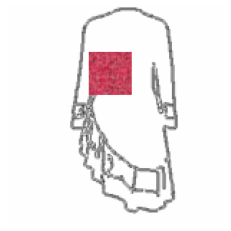

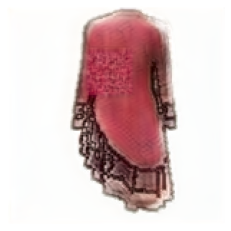

In [134]:
color_space = 'lab'

#data = valLoader.__iter__().__next__()

img, skg, seg, eroded_seg, txt = data

img = custom_transforms.normalize_lab(img)
skg = custom_transforms.normalize_lab(skg)
txt = custom_transforms.normalize_lab(txt)
seg = custom_transforms.normalize_seg(seg)
eroded_seg = custom_transforms.normalize_seg(eroded_seg)
inp,texture_loc = get_input(data,-1,-1,30,1)

seg = seg!=0

model = netG

inpv = get_inputv(inp.cpu())
output = model(inpv.cpu())

out_img = vis_image(custom_transforms.denormalize_lab(output.data.double().cpu()),
                                    color_space)
inp_img = vis_patch(custom_transforms.denormalize_lab(txt.cpu()),
                            custom_transforms.denormalize_lab(skg.cpu()),
                            texture_loc,
                            color_space)
tar_img = vis_image(custom_transforms.denormalize_lab(img.cpu()),
                        color_space)

plt.figure()
plt.imshow(np.transpose(inp_img[0],(1, 2, 0)))
plt.axis('off')
#plt.figure()  
plt.figure()
plt.imshow(np.transpose(out_img[0],(1, 2, 0)))
plt.axis('off')

In [135]:
print(out_img[0].shape)

(3, 152, 152)


In [136]:
img =out_img[0]

In [137]:
#Need to add resize code here

TypeError: Image data of dtype object cannot be converted to float

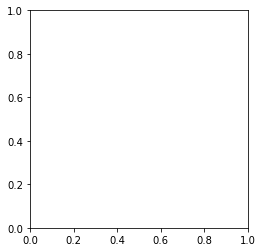

In [138]:
#convert input sketch to canny 
#path should be changed here
input_img = cv2.imread("C:/Users/ASUS/Desktop/1.jpg") #path to cloth folder
plt.imshow(input_img)

In [ ]:
print(input_img.shape)

In [ ]:
gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)



In [ ]:
#find the edges and cacluated thresholders with contours
thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

In [ ]:
edges = cv2.dilate(cv2.Canny(thresh,0,255), None)
plt.imshow(edges)

In [ ]:
masked = []
segmented = []

In [ ]:
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]

In [ ]:
#create a mask using largest contour
mask = np.zeros((256,256), np.uint8)
masked.append(cv2.drawContours(mask, [cnt], -1, 255, -1))

In [ ]:
print(mask.shape)

In [ ]:
dst = cv2.bitwise_and(input_img, input_img, mask=mask)

In [ ]:
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

In [ ]:
print(segmented.shape)

In [ ]:
plt.imshow(segmented)